# 📈 Improved Linear Regression for Next-Day Price Prediction

### 📘 Introduction
This notebook builds on the baseline linear regression model developed in `02.1_Linear_Regression_Model_baseline.ipynb`. The baseline used all identified linear features to predict next-day stock closing prices. Here, we focus on improving the model by expanding beyond the linear relationships, and creating feature space with polynomial and interaction terms, and tuning model hyperparameters (Ridge, Lasso).

We will also evaluate the model per stock ticker, track key metrics (R², MAE, MAPE), and prepare for future walk-forward validation.

## 📌 Context & Motivation
In the previous notebook, we explored baseline linear regression models to predict next-day closing prices for a set of stocks. That analysis helped us:

- Understand basic linear relationships between features and targets
- Identify important preprocessing steps (e.g., scaling, removing leaky features)
- Establish a baseline R² performance using a simple Linear Regression model

While promising, that approach had room for improvement in terms of capturing non-linear relationships and richer interactions.

## 🎯 Objective of This Notebook
This notebook builds upon the baseline by improving the linear regression model through advanced feature engineering and more robust evaluation:

- ✅ **Polynomial Features** — capture non-linear relationships
- ✅ **Interaction Terms** — introduce key cross-feature signals (e.g., lag × volume)
- ✅ **Model Pipeline** — clean, reproducible training pipeline
- ✅ **Advanced Evaluation** — MAE, MAPE, RMSE, R², and residual diagnostics

## 🧭 Next Steps Preview
In upcoming notebooks, we will:

- 🔁 Implement walk-forward validation to simulate real-world model deployment
- ⏳ Extend the model to longer timeframes (e.g., 5d, 10d, 30d predictions)
- 🌲 Explore tree-based models (Random Forest, XGBoost, LightGBM) for performance gains
- 🔄 Deploy the model to make **daily predictions on new incoming market data**


### 📦 1. Library Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

### 2. 📥 Load Cleaned Data (1-Day Horizon) 

#### Begin by loading the data dictionary we saved in the previous notebook

In [38]:
import pickle

file_path = "/Users/beatawyspianska/Desktop/AIML_Projects/predict_stock_price/stock-price-predictor/data/data_bundles/data_bundles.pkl"

with open(file_path, "rb") as f:
    data_bundles = pickle.load(f)

type(data_bundles)
print(data_bundles.keys())

dict_keys([1, 5, 7, 10, 14, 20, 30, 60])


#### Check key 1 (corresponding to 1 day time frame)

In [39]:
data_bundles[1].keys()

dict_keys(['X_train_clean', 'X_val_clean', 'X_test_clean'])

#### Extract the cleaned X data sets for 1 day time horizon

In [40]:
h = 1

X_train_clean = data_bundles[h]['X_train_clean']
X_val_clean   = data_bundles[h]['X_val_clean']
X_test_clean  = data_bundles[h]['X_test_clean']

# Check shapes of the loaded data
print(f"X_train_clean shape: {X_train_clean.shape}")
print(f"X_val_clean shape:   {X_val_clean.shape}")
print(f"X_test_clean shape:  {X_test_clean.shape}")

X_train_clean shape: (49121, 114)
X_val_clean shape:   (14034, 114)
X_test_clean shape:  (7018, 114)


### 🎯 3. Create y (target) vectors

View all columns in X_train

In [41]:
# View all columns in X_train
print(f"Number of features in X_train_clean: {len(X_train_clean.columns)}")
print("---------------------------------------------------------------------------------------------------------------------")

# Print list of features
columns = list(X_train_clean.columns)
print("List of features (10 per line):")
for i in range(0, len(columns), 10):
    print(columns[i:i+10])

Number of features in X_train_clean: 114
---------------------------------------------------------------------------------------------------------------------
List of features (10 per line):
['Date', 'TICKER', 'MarketCap', 'MarketCapBin', 'Close', 'High', 'Low', 'Open', 'Volume', 'NASDAQ_return_1']
['NASDAQ_lag_1', 'SP500_return_1', 'SP500_lag_1', 'High-Low', 'Price-Open', 'open_to_close_return', 'high_to_close_return', 'day_of_week', 'is_month_start', 'is_month_end']
['is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end', 'avg_volume_20', 'volume_norm', 'rolling_vwap_20', 'Return_1', 'close_diff1', 'close_diff2']
['price_over_SMA_200', 'ADX_14', 'RSI_14', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0', 'bb_bandwidth_50', 'long_volatility_50']
['MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'macd_diff', 'macd_signal', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'OBV', 'cmf_20', 'ATR_14']
['cci_20', 'williams_r', 'daily_return', 'swing_direction', 'trend_return'

Pick "Target_Raw_Close_daily" for our target columns and define features to drop

In [42]:
# Prepare Columns to exclude from X after defining y
# Target Columns
target_cols = [
'Target_Raw_Close_daily', 'Target_Log_Return_daily', 'Target_%_Return_daily', 'Target_Direction_daily', 'Target_Raw_Close_5d', 
'Target_%_Return_5d', 'Target_Log_Return_5d', 'Target_Direction_5d', 'Target_Raw_Close_7d', 'Target_%_Return_7d', 
'Target_Log_Return_7d', 'Target_Direction_7d', 'Target_Raw_Close_10d', 'Target_%_Return_10d', 'Target_Log_Return_10d', 
'Target_Direction_10d', 'Target_Raw_Close_14d', 'Target_%_Return_14d', 'Target_Log_Return_14d', 'Target_Direction_14d', 
'Target_Raw_Close_20d', 'Target_%_Return_20d', 'Target_Log_Return_20d', 'Target_Direction_20d', 'Target_Raw_Close_30d', 
'Target_%_Return_30d', 'Target_Log_Return_30d', 'Target_Direction_30d', 'Target_Raw_Close_60d', 'Target_%_Return_60d', 
'Target_Log_Return_60d', 'Target_Direction_60d'
]

# leaky features
leaky_features = ['Close', 'Open', 'High', 'Low', 'trend_id', 'trend_duration', 'is_trend_start',]

# other columns to condier for removal when training
other_cols = ['Date','TICKER','Sector']

Define targets

In [43]:
# Define targets
y_train = X_train_clean["Target_Raw_Close_daily"]
y_val = X_val_clean["Target_Raw_Close_daily"]
y_test = X_test_clean["Target_Raw_Close_daily"]

# Print the shape of the target vectors to confirm they are correct
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape:   {y_val.shape}")
print(f"y_test shape:  {y_test.shape}")

y_train shape: (49121,)
y_val shape:   (14034,)
y_test shape:  (7018,)


Remove Target Columns from X sets and check shape

In [44]:
# Remove Target Columns from X sets and check shape
X_train_clean = X_train_clean.drop(columns=target_cols + leaky_features)
X_val_clean = X_val_clean.drop(columns=target_cols + leaky_features)
X_test_clean = X_test_clean.drop(columns=target_cols + leaky_features)

# Print the shapes after removing target columns
print(f"X_train_clean shape after removing target columns: {X_train_clean.shape}")
print(f"X_val_clean shape after removing target columns:   {X_val_clean.shape}")
print(f"X_test_clean shape after removing target columns:  {X_test_clean.shape}")

X_train_clean shape after removing target columns: (49121, 75)
X_val_clean shape after removing target columns:   (14034, 75)
X_test_clean shape after removing target columns:  (7018, 75)


#### Check reamining features in X_train - after removing leaky features and target columns

In [45]:
print(f"Number of features in X_train_clean: {len(X_train_clean.columns)}")
print("---------------------------------------------------------------------------------------------------------------------")

# Print list of features
columns = list(X_train_clean.columns)
print("List of features (10 per line):")
for i in range(0, len(columns), 10):
    print(columns[i:i+10])

Number of features in X_train_clean: 75
---------------------------------------------------------------------------------------------------------------------
List of features (10 per line):
['Date', 'TICKER', 'MarketCap', 'MarketCapBin', 'Volume', 'NASDAQ_return_1', 'NASDAQ_lag_1', 'SP500_return_1', 'SP500_lag_1', 'High-Low']
['Price-Open', 'open_to_close_return', 'high_to_close_return', 'day_of_week', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end']
['avg_volume_20', 'volume_norm', 'rolling_vwap_20', 'Return_1', 'close_diff1', 'close_diff2', 'price_over_SMA_200', 'ADX_14', 'RSI_14', 'BBL_5_2.0']
['BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0', 'bb_bandwidth_50', 'long_volatility_50', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'macd_diff']
['macd_signal', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'OBV', 'cmf_20', 'ATR_14', 'cci_20', 'williams_r', 'daily_return', 'swing_direction']
['trend_return', 'trend_range', 'swing_trend', '

### 📐 4. Restrict to Features with Known Linear Relationship

In [46]:
# These features were previously identified as linearly related to next-day price
# Nothe that the following traget columns also showed linear relationship with "Target_Raw_Close_daily": 'Target_Raw_Close_5d', 'Target_Raw_Close_7d', 'Target_Raw_Close_10d', 'Target_Raw_Close_14d', and 'Target_Raw_Close_20d'
linear_features = [
    'Close_lag1', 'BBM_5_2.0', 'BBU_5_2.0', 'BBL_5_2.0', 'rolling_vwap_20'
]

# Target column
target_col = "Target_Raw_Close_daily"

# Subset the datasets
X_train_linear = X_train_clean[linear_features + ["TICKER"] + ["Date"].copy()]
X_val_linear   = X_val_clean[linear_features + ["TICKER"] +["Date"].copy()]
X_test_linear  = X_test_clean[linear_features + ["TICKER"] +["Date"].copy()]

# Check which features are present in the training set
linear_features_clean = [feature for feature in linear_features if feature in X_train_linear.columns]
# Print the features that are present
print("Linear features present in X_train_linear:")
print("-------------------------------------------------------------------------------------------------------------------")
for feature in linear_features_clean:
    print(feature)
# Check the shapes of the linear datasets
print("-------------------------------------------------------------------------------------------------------------------")
print(f"X_train_linear shape: {X_train_linear.shape}")
print(f"X_val_linear shape:   {X_val_linear.shape}")
print(f"X_test_linear shape:  {X_test_linear.shape}")

# head of X_train_linear
print("-------------------------------------------------------------------------------------------------------------------")
print("First few rows of X_train_linear:")
print(X_train_linear.head(5))
# Plot linear features in X_train in 3x2 grid

Linear features present in X_train_linear:
-------------------------------------------------------------------------------------------------------------------
Close_lag1
BBM_5_2.0
BBU_5_2.0
BBL_5_2.0
rolling_vwap_20
-------------------------------------------------------------------------------------------------------------------
X_train_linear shape: (49121, 7)
X_val_linear shape:   (14034, 7)
X_test_linear shape:  (7018, 7)
-------------------------------------------------------------------------------------------------------------------
First few rows of X_train_linear:
   Close_lag1  BBM_5_2.0  BBU_5_2.0  ...  rolling_vwap_20  TICKER       Date
0    9.471738   9.293745   9.843404  ...         9.312099     BAC 2013-03-07
1   48.562622  48.709701  49.323691  ...        47.834561     SHW 2013-03-07
2   35.620598  35.337228  36.233063  ...        34.773339     JPM 2013-03-07
3   22.888927  22.926410  23.136023  ...        22.606413    MSFT 2013-03-07
4    2.512667   2.437333   2.613034

### 🌐🤏 5. Add Polynimila and Interaction features 

In [54]:
#Add interaction & polynomial features to all datasets
import numpy as np
import pandas as pd

# Select only numeric columns for polynomial expansion
X_train_poly_input = X_train_linear.select_dtypes(include=[np.number])
X_val_poly_input   = X_val_linear.select_dtypes(include=[np.number])
X_test_poly_input  = X_test_linear.select_dtypes(include=[np.number])

# Initialize PolynomialFeatures with degree 2 (for quadratic features)
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

X_train_poly = poly.fit_transform(X_train_poly_input)
X_val_poly   = poly.transform(X_val_poly_input)
X_test_poly  = poly.transform(X_test_poly_input)

# Get new feature names
poly_feature_names = poly.get_feature_names_out(X_train_poly_input.columns)

# Convert back to DataFrame
X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly_feature_names, index=X_train_linear.index)
X_val_poly_df   = pd.DataFrame(X_val_poly, columns=poly_feature_names, index=X_val_linear.index)
X_test_poly_df  = pd.DataFrame(X_test_poly, columns=poly_feature_names, index=X_test_linear.index)

# Optionally: Add back 'TICKER' and 'Date' for groupby/evaluation
X_train_poly_df[['TICKER', 'Date']] = X_train_linear[['TICKER', 'Date']]
X_val_poly_df[['TICKER', 'Date']]   = X_val_linear[['TICKER', 'Date']]
X_test_poly_df[['TICKER', 'Date']]  = X_test_linear[['TICKER', 'Date']]

# print the new feature names
print("-------------------------------------------------------------------------------------------------------------------")
print("New feature names after polynomial expansion:")
print(poly_feature_names)
# check the first few rows of the new DataFrames
print("-------------------------------------------------------------------------------------------------------------------")
print("First few rows of X_train_poly_df:")
print(X_train_poly_df.head(5))
# Check the shapes of the new DataFrames
print("-------------------------------------------------------------------------------------------------------------------")
print(f"X_train_poly_df shape: {X_train_poly_df.shape}")
print(f"X_val_poly_df shape:   {X_val_poly_df.shape}")
print(f"X_test_poly_df shape:  {X_test_poly_df.shape}")

-------------------------------------------------------------------------------------------------------------------
New feature names after polynomial expansion:
['Close_lag1' 'BBM_5_2.0' 'BBU_5_2.0' 'BBL_5_2.0' 'rolling_vwap_20'
 'Close_lag1^2' 'Close_lag1 BBM_5_2.0' 'Close_lag1 BBU_5_2.0'
 'Close_lag1 BBL_5_2.0' 'Close_lag1 rolling_vwap_20' 'BBM_5_2.0^2'
 'BBM_5_2.0 BBU_5_2.0' 'BBM_5_2.0 BBL_5_2.0' 'BBM_5_2.0 rolling_vwap_20'
 'BBU_5_2.0^2' 'BBU_5_2.0 BBL_5_2.0' 'BBU_5_2.0 rolling_vwap_20'
 'BBL_5_2.0^2' 'BBL_5_2.0 rolling_vwap_20' 'rolling_vwap_20^2']
-------------------------------------------------------------------------------------------------------------------
First few rows of X_train_poly_df:
   Close_lag1  BBM_5_2.0  BBU_5_2.0  ...  rolling_vwap_20^2  TICKER       Date
0    9.471738   9.293745   9.843404  ...          86.715183     BAC 2013-03-07
1   48.562622  48.709701  49.323691  ...        2288.145181     SHW 2013-03-07
2   35.620598  35.337228  36.233063  ...        120

### 📊 5. Scale Data, Train Linear Regression using the newly created interaction and plynomila features, and Evaluate Performance

In [55]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_poly)
X_val_scaled   = scaler.transform(X_val_poly)
X_test_scaled  = scaler.transform(X_test_poly)

### 🧪 Define Evaluation Function per Ticker

In [56]:
import pandas as pd

def evaluate_model_per_ticker(model, X, y, tickers):
    results = []
    unique_tickers = tickers.unique()
    for ticker in unique_tickers:
        idx = tickers == ticker
        y_true = y[idx]
        y_pred = model.predict(X[idx])
        results.append({
            'Ticker': ticker,
            'R2': r2_score(y_true, y_pred),
            'MAE': mean_absolute_error(y_true, y_pred),
            'MAPE': mean_absolute_percentage_error(y_true, y_pred)
        })
    return pd.DataFrame(results)

### 🔍 Fit and Compare Linear, Ridge, and Lasso Models (with GridSearch for Ridge & Lasso)

In [57]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV

# Fit plain Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# Ridge and Lasso with grid search
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]

ridge_grid = GridSearchCV(Ridge(), {'alpha': alphas}, cv=5, scoring='r2')
ridge_grid.fit(X_train_scaled, y_train)

lasso_grid = GridSearchCV(Lasso(max_iter=10000), {'alpha': alphas}, cv=5, scoring='r2')
lasso_grid.fit(X_train_scaled, y_train)

print("Best Ridge alpha:", ridge_grid.best_params_)
print("Best Lasso alpha:", lasso_grid.best_params_)

Best Ridge alpha: {'alpha': 0.01}
Best Lasso alpha: {'alpha': 0.01}


### 🧾 Evaluate Best Models on Validation Set per Ticker

In [58]:
# Make sure you have 'TICKER' column to group by
val_tickers = X_val_poly_df['TICKER']

# Evaluate models per ticker
lin_reg_results = evaluate_model_per_ticker(lin_reg, X_val_scaled, y_val, val_tickers)
ridge_results   = evaluate_model_per_ticker(ridge_grid.best_estimator_, X_val_scaled, y_val, val_tickers)
lasso_results   = evaluate_model_per_ticker(lasso_grid.best_estimator_, X_val_scaled, y_val, val_tickers)

# Add model name
lin_reg_results['Model'] = 'Linear Regression'
ridge_results['Model']   = 'Ridge'
lasso_results['Model']   = 'Lasso'

# Combine
results_df = pd.concat([lin_reg_results, ridge_results, lasso_results], ignore_index=True)
results_df.sort_values(by='R2', ascending=False, inplace=True)

# Display top 10 performing ticker-model combos
results_df.head(20)


,Ticker,R2,MAE,MAPE,Model
9,NVDA,0.990017,0.956030,0.036616,Linear Regression
32,NVDA,0.990005,0.956468,0.036628,Ridge
55,NVDA,0.989513,0.975433,0.037278,Lasso
57,META,0.984754,6.674825,0.030473,Lasso
6,XOM,0.984604,1.699631,0.019894,Linear Regression
29,XOM,0.984583,1.701940,0.019923,Ridge
52,XOM,0.984208,1.748124,0.020503,Lasso
34,META,0.984190,6.742598,0.030539,Ridge
11,META,0.983188,6.815788,0.030878,Linear Regression
17,LIN,0.977066,4.678892,0.014909,Linear Regression


### 📉 Baseline Persistence Model

In [ ]:
# Predict tomorrow's price as today's price (i.e., use Close_lag1)
baseline_preds = X_val_clean["Close_lag1"]  # From raw cleaned validation data (not scaled)

# Evaluate just like others
def evaluate_baseline(y_true, baseline_preds, tickers):
    results = []
    for ticker in tickers.unique():
        idx = tickers == ticker
        y_ticker = y_true[idx]
        y_pred_ticker = baseline_preds[idx]
        results.append({
            "Ticker": ticker,
            "R2": r2_score(y_ticker, y_pred_ticker),
            "MAE": mean_absolute_error(y_ticker, y_pred_ticker),
            "MAPE": mean_absolute_percentage_error(y_ticker, y_pred_ticker),
            "Model": "Baseline (Persistence)"
        })
    return pd.DataFrame(results)

baseline_results = evaluate_baseline(y_val, baseline_preds, val_tickers)

# ✅ Combine all results
results_df = pd.concat([results_df, baseline_results], ignore_index=True)
results_df.sort_values(by="R2", ascending=False, inplace=True)

### 🖼 Visualize model performance per ticker

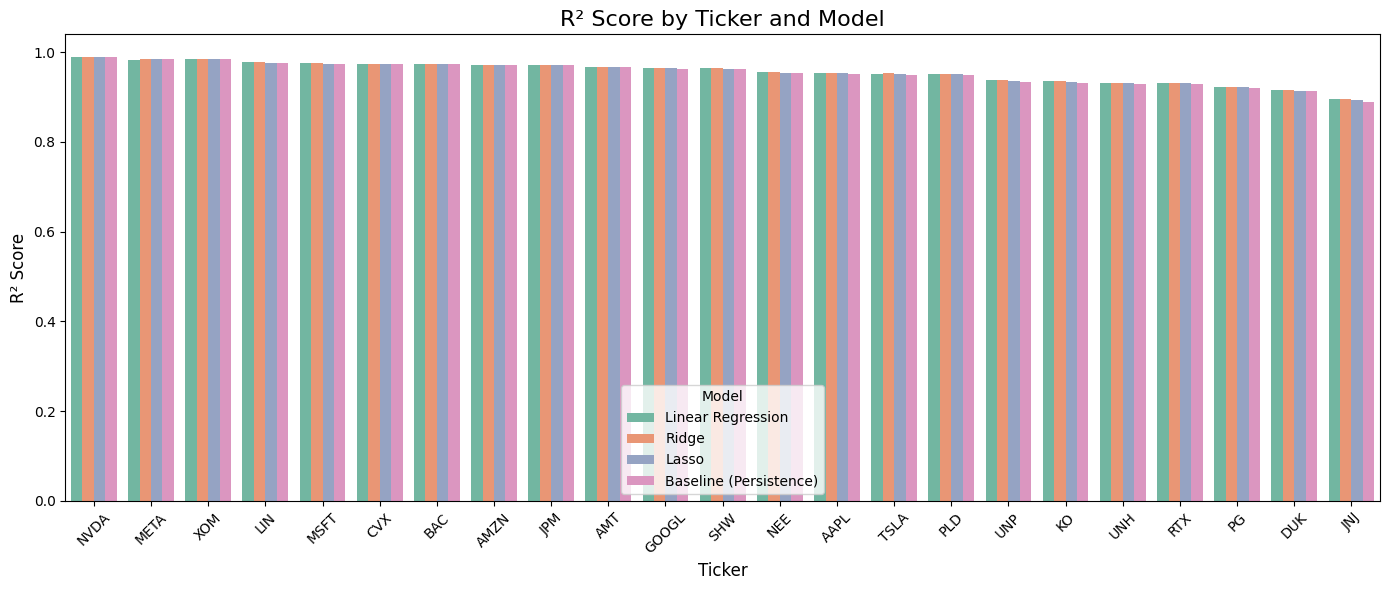

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.barplot(
    data=results_df,
    x="Ticker",       # <-- Fixed here
    y="R2",
    hue="Model",
    palette="Set2"
)

plt.title("R² Score by Ticker and Model", fontsize=16)
plt.xlabel("Ticker", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.legend(title="Model", fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

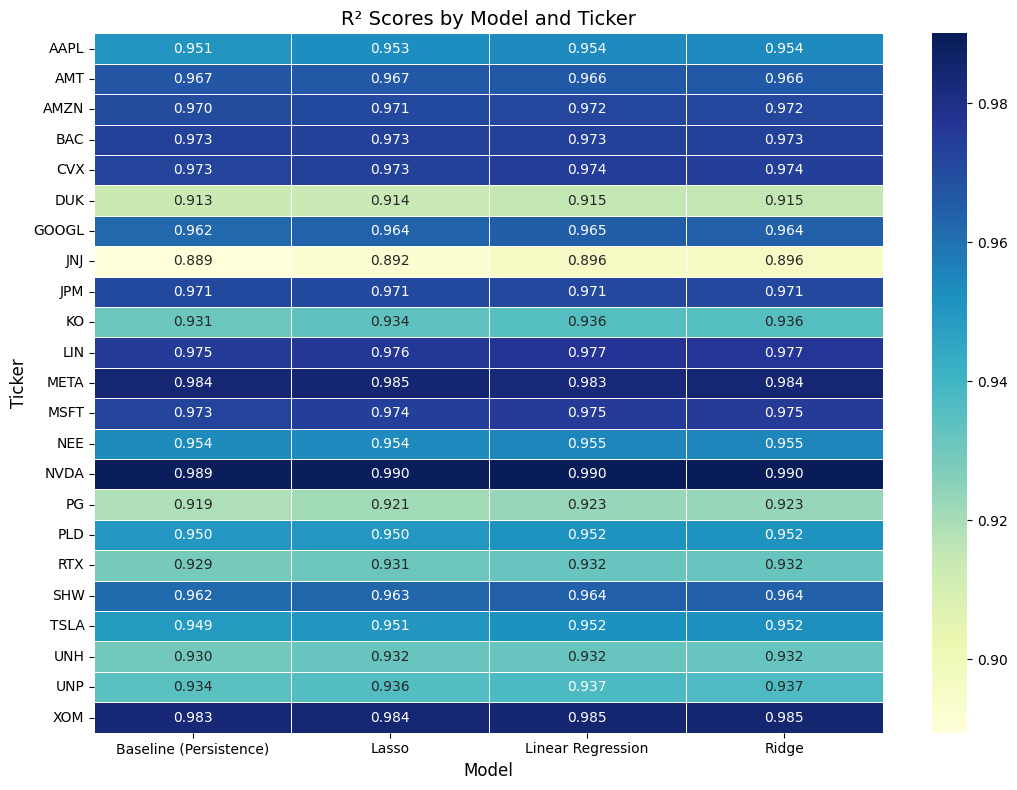

In [64]:
pivot = results_df.pivot_table(index="Ticker", columns="Model", values="R2")

plt.figure(figsize=(11, 8))  # Adjust width/height based on # of tickers
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".3f", linewidths=0.5)

plt.title("R² Scores by Model and Ticker", fontsize=14)
plt.ylabel("Ticker", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.tight_layout()
plt.show()
